In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
class CNN1d(tf.keras.Model):
    def __init__(self, conv1_filters, conv1_size, conv2_filters, conv2_size, dense1, encoder):
        super(CNN1d, self).__init__()

        self.encoder = encoder

        vocab = encoder.get_vocabulary()
        
        self.embedding = tf.keras.layers.Embedding(input_dim=len(vocab),output_dim=64,mask_zero=True)
        

        self.conv1 = tf.keras.layers.Conv1D(filters=conv1_filters,
                            kernel_size=conv1_size,
                            padding="same",
                            activation="relu",
                            data_format="channels_last",
                            )
        self.conv2 = tf.keras.layers.Conv1D(filters=conv2_filters,
                            kernel_size=conv2_size,
                            padding="same",
                            activation="relu",
                            data_format="channels_last",
                            )
        self.global_pool = tf.keras.layers.GlobalMaxPool1D(keepdims=False)
        self.dense1 = tf.keras.layers.Dense(dense1, activation='relu')
        self.dense2 = tf.keras.layers.Dense(3, activation="softmax")

    def call(self, x, training=False):
        emb = self.encoder(x)
        emb = self.embedding(emb)
        conv1 = self.conv1(emb)
        conv2 = self.conv2(emb)
        z = tf.concat([conv1, conv2], axis=2)
        z = self.global_pool(z)
        z = self.dense1(z)
        z = self.dense2(z)
        return z


In [3]:
df = pd.read_csv("train.csv")
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
X = df["text"].copy()
authors = df["author"].copy()

# Label data
y = []
for author in authors:
    if author == "EAP":
        y.append([1, 0, 0])
    if author == "HPL":
        y.append([0, 1, 0])
    if author == "MWS":
        y.append([0, 0, 1])

y = np.array(y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(X_train)
# vocab = encoder.get_vocabulary()

In [7]:
def create_model(conv1_filters, conv1_size, conv2_filters, conv2_size, dense1):
    model = CNN1d(conv1_filters, conv1_size, conv2_filters, conv2_size, dense1, encoder)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy']
    )
    return model
  

In [8]:
model = KerasClassifier(build_fn=create_model, batch_size=32, verbose=1)

conv1_filters = [8, 16, 32, 64, 128]
conv2_filters = [8, 16, 32, 64, 128]
conv1_size = [2, 3, 4, 5, 6]
conv2_size = [2, 3, 4, 5, 6]
dense1 = [8, 16, 32, 64, 128]

params = dict(conv1_filters=conv1_filters, conv2_filters=conv2_filters, conv1_size=conv1_size, conv2_size=conv2_size, dense1=dense1)
grid = RandomizedSearchCV(estimator=model, scoring = 'neg_log_loss', param_distributions=params, n_jobs=1, cv=3, verbose=3)

grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] dense1=16, conv2_size=5, conv2_filters=64, conv1_size=3, conv1_filters=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


327/327 [==============================] - 51s 63ms/step - loss: 0.9338 - accuracy: 0.5369
[CV]  dense1=16, conv2_size=5, conv2_filters=64, conv1_size=3, conv1_filters=8, score=-0.666, total=  53.2s
[CV] dense1=16, conv2_size=5, conv2_filters=64, conv1_size=3, conv1_filters=8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.2s remaining:    0.0s


327/327 [==============================] - 6s 15ms/step - loss: 0.8947 - accuracy: 0.5817
[CV]  dense1=16, conv2_size=5, conv2_filters=64, conv1_size=3, conv1_filters=8, score=-0.604, total=   6.5s
[CV] dense1=16, conv2_size=5, conv2_filters=64, conv1_size=3, conv1_filters=8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.7s remaining:    0.0s


327/327 [==============================] - 4s 9ms/step - loss: 0.9274 - accuracy: 0.5459
[CV]  dense1=16, conv2_size=5, conv2_filters=64, conv1_size=3, conv1_filters=8, score=-0.639, total=   6.6s
[CV] dense1=16, conv2_size=3, conv2_filters=8, conv1_size=6, conv1_filters=16 
327/327 [==============================] - 10s 28ms/step - loss: 0.9353 - accuracy: 0.5537
[CV]  dense1=16, conv2_size=3, conv2_filters=8, conv1_size=6, conv1_filters=16, score=-0.668, total=  11.0s
[CV] dense1=16, conv2_size=3, conv2_filters=8, conv1_size=6, conv1_filters=16 
327/327 [==============================] - 4s 11ms/step - loss: 0.9893 - accuracy: 0.5028
[CV]  dense1=16, conv2_size=3, conv2_filters=8, conv1_size=6, conv1_filters=16, score=-0.802, total=   6.5s
[CV] dense1=16, conv2_size=3, conv2_filters=8, conv1_size=6, conv1_filters=16 
327/327 [==============================] - 4s 8ms/step - loss: 0.9545 - accuracy: 0.5404
[CV]  dense1=16, conv2_size=3, conv2_filters=8, conv1_size=6, conv1_filters=16, 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.7min finished


490/490 [==============================] - 5s 10ms/step - loss: 0.7207 - accuracy: 0.6691
Best: -0.538648 using {'dense1': 128, 'conv2_size': 4, 'conv2_filters': 16, 'conv1_size': 4, 'conv1_filters': 128}


In [9]:
callbacks = [
          tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
          tf.keras.callbacks.ModelCheckpoint(
            filepath="CNN_weights",
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
]
with tf.device('/device:GPU:0'):
  model = create_model(16, 6, 128, 5, 128)
  history = model.fit(X_train, y_train, epochs=15,
                      validation_data=(X_test, y_test),
                      validation_steps=30,
                      callbacks=callbacks)

Epoch 1/15
490/490 [==============================] - 23s 45ms/step - loss: 0.7169 - accuracy: 0.6750 - val_loss: 0.4952 - val_accuracy: 0.8016
Epoch 2/15
490/490 [==============================] - 5s 11ms/step - loss: 0.2259 - accuracy: 0.9187 - val_loss: 0.4826 - val_accuracy: 0.8202
Epoch 3/15
490/490 [==============================] - 5s 10ms/step - loss: 0.0568 - accuracy: 0.9829 - val_loss: 0.6060 - val_accuracy: 0.8202
Epoch 4/15
490/490 [==============================] - 5s 10ms/step - loss: 0.0140 - accuracy: 0.9966 - val_loss: 0.7266 - val_accuracy: 0.8062
Epoch 5/15
490/490 [==============================] - 5s 9ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.7739 - val_accuracy: 0.8169


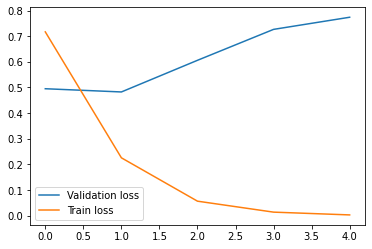

In [10]:
# Plot validation loss as a function of the epoch number
plt.plot(history.history["val_loss"], label="Validation loss")
plt.plot(history.history["loss"], label="Train loss")
plt.legend()

In [11]:
def confusion(predictions, test_labels):
    matrix = np.zeros([3,3], dtype=int)
    
    i = 0
    for row in predictions:
        matrix[np.argmax(row), np.argmax(test_labels[i])] += 1
        i += 1
        
    return matrix

In [12]:
model.load_weights("CNN_weights")
print(model.evaluate(X_test, y_test))
predict = model.predict(X_test)

123/123 [==============================] - 1s 7ms/step - loss: 0.4827 - accuracy: 0.8202
[0.48273736238479614, 0.8202247023582458]


Text(33.0, 0.5, 'True')

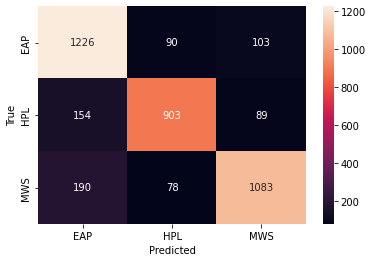

In [13]:
x_axis_labels = ['EAP', 'HPL', 'MWS']
y_axis_labels = ['EAP', 'HPL', 'MWS']

ax = sns.heatmap(confusion(predict, y_test), xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [14]:
df_sub = pd.read_csv("test.csv")
X_sub = df_sub["text"].copy()

In [15]:
submission_pred = model.predict(X_sub)
submission_pred

array([[5.6480877e-02, 9.6532120e-04, 9.4255376e-01],
       [9.4762290e-01, 3.3660047e-02, 1.8716987e-02],
       [7.1637081e-03, 9.9227035e-01, 5.6593656e-04],
       ...,
       [2.5906494e-01, 8.4338244e-03, 7.3250127e-01],
       [4.9042657e-01, 2.2098618e-02, 4.8747477e-01],
       [1.5670020e-02, 9.8404109e-01, 2.8891972e-04]], dtype=float32)

In [16]:
submission = pd.DataFrame({
    "id": df_sub["id"],
    "EAP": submission_pred[:, 0],
    "HPL": submission_pred[:, 1],
    "MWS": submission_pred[:, 2]
})
submission

,id,EAP,HPL,MWS
0,id02310,0.056481,0.000965,0.942554
1,id24541,0.947623,0.033660,0.018717
2,id00134,0.007164,0.992270,0.000566
3,id27757,0.821433,0.047785,0.130781
4,id04081,0.990820,0.001456,0.007724
...,...,...,...,...
8387,id11749,0.290476,0.003158,0.706365
8388,id10526,0.017635,0.007522,0.974843
8389,id13477,0.259065,0.008434,0.732501
8390,id13761,0.490427,0.022099,0.487475


In [17]:
submission.to_csv("submission.csv", index=False)